In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from d2l import torch as d2l

#### 数据集

In [2]:
train_data = pd.read_csv('./Dataset/train.csv')
test_data = pd.read_csv('./Dataset/test.csv')
train_data.shape

(891, 12)

In [3]:
train_data.iloc[0:1, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [4]:
test_data.iloc[0:1, :]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [5]:
train_labels = torch.tensor(train_data.Survived.values.reshape(-1,1), dtype=torch.float32)
train_labels.shape

torch.Size([891, 1])

In [6]:
train_data = train_data.drop(labels=['PassengerId', 'Survived', 'Name', 'Ticket', 'Fare', 'Cabin'], axis=1)
test_data = test_data.drop(labels=['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], axis=1)

In [7]:
all_features = pd.concat((train_data, test_data))
all_features.iloc[0:6, :]

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,22.0,1,0,S
1,1,female,38.0,1,0,C
2,3,female,26.0,0,0,S
3,1,female,35.0,1,0,S
4,3,male,35.0,0,0,S
5,3,male,NaN,0,0,Q


In [8]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()) 
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features.iloc[0:6, :]

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0.841595,male,-0.546789,0.481104,-0.444829,S
1,-1.545507,female,0.563282,0.481104,-0.444829,C
2,0.841595,female,-0.269271,-0.478904,-0.444829,S
3,-1.545507,female,0.355144,0.481104,-0.444829,S
4,0.841595,male,0.355144,-0.478904,-0.444829,S
5,0.841595,male,0.000000,-0.478904,-0.444829,Q


In [9]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.iloc[0:6, :]

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,0.841595,-0.546789,0.481104,-0.444829,0,1,0,0,0,1,0
1,-1.545507,0.563282,0.481104,-0.444829,1,0,0,1,0,0,0
2,0.841595,-0.269271,-0.478904,-0.444829,1,0,0,0,0,1,0
3,-1.545507,0.355144,0.481104,-0.444829,1,0,0,0,0,1,0
4,0.841595,0.355144,-0.478904,-0.444829,0,1,0,0,0,1,0
5,0.841595,0.000000,-0.478904,-0.444829,0,1,0,0,1,0,0


In [10]:
all_features.shape

(1309, 11)

In [38]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_features.shape

torch.Size([891, 11])

In [39]:
train_iter = d2l.load_array((train_features, train_labels), 64)

#### 网络

In [47]:
model_name = 'softmax'
loss = torch.nn.MSELoss()
in_features = train_features.shape[1] 

In [41]:
class BaseLine_Net(nn.Module):
    def __init__(self):
        super(BaseLine_Net, self).__init__()
        self.softmax_layer = nn.Sequential(
            nn.Linear(in_features, 2),
            nn.Softmax(1)
        )
    def forward(self, x):
        y = self.softmax_layer(x)
        return y
model = BaseLine_Net()
model

BaseLine_Net(
  (softmax_layer): Sequential(
    (0): Linear(in_features=11, out_features=2, bias=True)
    (1): Softmax(dim=1)
  )
)

In [42]:
def NetInit(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0, std=0.01)
model.apply(NetInit)

BaseLine_Net(
  (softmax_layer): Sequential(
    (0): Linear(in_features=11, out_features=2, bias=True)
    (1): Softmax(dim=1)
  )
)

In [43]:
learning_rate = 0.1
opt = torch.optim.SGD(model.parameters(),lr = learning_rate)

In [44]:
for step, (X, y) in enumerate(train_iter):
    if (step > 0):
        print(y.squeeze().shape)
        break

torch.Size([64])


In [48]:
num_epochs = 30
acc_list, loss_list = [], []

for epoch in range(1, num_epochs+1):
    loss_sum, acc_sum = 0.0, 0.0
    n = 0
    for step, (X, y) in enumerate(train_iter):
        pred = model(X)
        l = loss(pred, y).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        loss_sum += l
        acc_sum += (pred.argmax(axis=1) == y.squeeze()).sum()
#         print(acc_sum)
        n+=len(y)
    loss_list.append(loss_sum/n)
    acc_list.append(acc_sum/n)
    print("epoch: %d, loss: %.4f, train_acc: %.4f" % (epoch, loss_sum/n, acc_sum/n))

epoch: 1, loss: 0.0040, train_acc: 0.3838
epoch: 2, loss: 0.0039, train_acc: 0.3838
epoch: 3, loss: 0.0039, train_acc: 0.3838
epoch: 4, loss: 0.0039, train_acc: 0.4613
epoch: 5, loss: 0.0039, train_acc: 0.5892
epoch: 6, loss: 0.0039, train_acc: 0.6072
epoch: 7, loss: 0.0039, train_acc: 0.6117
epoch: 8, loss: 0.0039, train_acc: 0.6016
epoch: 9, loss: 0.0039, train_acc: 0.5993
epoch: 10, loss: 0.0039, train_acc: 0.5993
epoch: 11, loss: 0.0039, train_acc: 0.5982
epoch: 12, loss: 0.0039, train_acc: 0.6027
epoch: 13, loss: 0.0039, train_acc: 0.6027
epoch: 14, loss: 0.0039, train_acc: 0.6038
epoch: 15, loss: 0.0039, train_acc: 0.6027
epoch: 16, loss: 0.0039, train_acc: 0.6049
epoch: 17, loss: 0.0039, train_acc: 0.6038
epoch: 18, loss: 0.0039, train_acc: 0.6049
epoch: 19, loss: 0.0039, train_acc: 0.6049
epoch: 20, loss: 0.0039, train_acc: 0.6038
epoch: 21, loss: 0.0039, train_acc: 0.6049
epoch: 22, loss: 0.0039, train_acc: 0.6027
epoch: 23, loss: 0.0039, train_acc: 0.6038
epoch: 24, loss: 0.0

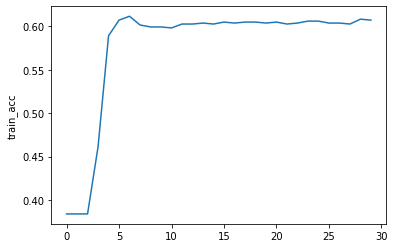

In [51]:
plt.ylabel('train_acc')
plt.plot(range(len(acc_list)),acc_list)

In [50]:
test_data_cv = pd.read_csv('./Dataset/test.csv')
preds = model(test_features).argmax(axis = 1).reshape(1,-1)[0]
test_data_cv['Survived'] = pd.Series(preds)
submission = pd.concat([test_data_cv['PassengerId'], test_data_cv['Survived']], axis=1)
submission.to_csv('submission2.csv', index=False)